<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> Binary Variational Semantic Hashing </h1>

<H3 align='center'> Extensión trabajo CIARP </H3>
<hr style="height:2px;border:none"/>

In [1]:
import numpy as np
import keras,gc, os, time, sys
from keras.layers import *
from keras.models import Sequential,Model
from keras import backend as K
from astropy.table import Table
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image

from base_networks import *
from utils import check_availability, load_imgs_mask

/home/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fmena/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fmena/.local/lib/python3.5/site-package

## Load Data

### MNIST
---

Imágenes en blanco y negro de 28x28 píxeles, de números del 0 al 9, que dan orígen a las 10 clases del problema.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|60000|10|
|Pruebas|10000|10|

In [2]:
name_dat = "MNIST"

(X_t, aux_t), (X_test, aux_test) = keras.datasets.mnist.load_data()
X_t = np.expand_dims(X_t, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
labels_t = np.asarray([labels[value] for value in aux_t])
labels_test = np.asarray([labels[value] for value in aux_test])
print("Datos de entrenamiento: ",len(X_t))
print("Datos de pruebas: ",len(X_test))

Datos de entrenamiento:  60000
Datos de pruebas:  10000


### CIFAR-10
---
Imágenes RGB pequeñas de  32x32 píxeles, de fotos naturales de distintos objetos.

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|50000|10|
|Pruebas|10000|10|

In [ ]:
name_dat = "CIFAR-10"

(X_t, aux_t), (X_test, aux_test) = keras.datasets.cifar10.load_data()

labels = ["airplane", "automobile","bird", "cat","deer","dog","frog","horse","ship","truck"]
labels_t = np.asarray([labels[value[0]] for value in aux_t])
labels_test = np.asarray([labels[value[0]] for value in aux_test])
print("Datos de entrenamiento: ",len(X_t))
print("Datos de pruebas: ",len(X_test))

### CelebA
---
* Cantidad de datos totales: 202599
* Datos en plataforma Kaggle:https://www.kaggle.com/jessicali9530/celeba-dataset 

Imágenes RGB re-dimensionadas a 64x64 píxeles, de fotos naturales de rostros de celebridades. Una muestra es utilizada

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|40|
|Validación|xxx|40|
|Pruebas|xxx|40|

mask_av = check_availability(folder+"small_images/", labels_t)
np.savetxt("./Data/+"name_dat+"_mask_avail.txt", mask_av, fmt="%1i")

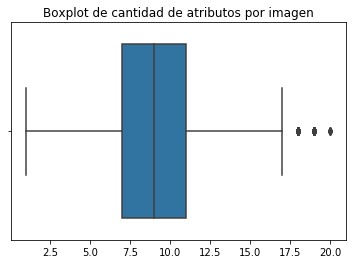

In [3]:
sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de topics por imagen")
plt.show()

In [ ]:
## top -K topics/categories a usar...

In [23]:
name_dat = "CelebA"
mask_av = np.loadtxt("./Data/"+name_dat+"_mask_avail.txt").astype(bool)


folder = "../CelebA/"

part = pd.read_csv(folder+"list_eval_partition.csv")
mask_train = (part["partition"].values == 0)[mask_av]
mask_val = (part["partition"].values == 1)[mask_av]
mask_test = (part["partition"].values == 2)[mask_av]

df_atrr = pd.read_csv(folder+"list_attr_celeba.csv")[mask_av]
img_names = df_atrr["image_id"].values
labels = list(df_atrr.columns[1:])
print("Cantidad de labels: ",len(labels) )

N_total = len(df_atrr)
print("Cantidad de objetos: ",N_total )
aux = (df_atrr == 1).values
labels_t = np.asarray([list(df_atrr.columns[aux[value]]) for value in range(N_total)])
labels[:5]

Cantidad de labels:  40
Cantidad de objetos:  202599


['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald']

In [64]:
N_used = 80*1000 #o 150k??
idx_all = np.arange(0, N_total)
mask_used = np.zeros(N_total, dtype=bool)
np.random.seed(10)
mask_used[np.random.choice(np.arange(0, N_total), size=N_used, replace=False)] = 1
mask_used

array([ True,  True, False, ..., False,  True,  True])

In [24]:
mask_used= np.ones(N_total, dtype=bool)

In [25]:
imgs_files = [folder+ "imgs_celebA/"+ name for name in img_names]

X_t = load_imgs_mask(imgs_files, mask_used, size=64) #images names to load
X_t.shape

El contador de lectura va en:  0
El contador de lectura va en:  10000
El contador de lectura va en:  20000
El contador de lectura va en:  30000
El contador de lectura va en:  40000
El contador de lectura va en:  50000
El contador de lectura va en:  60000
El contador de lectura va en:  70000
El contador de lectura va en:  80000
El contador de lectura va en:  90000
El contador de lectura va en:  100000
El contador de lectura va en:  110000
El contador de lectura va en:  120000
El contador de lectura va en:  130000
El contador de lectura va en:  140000
El contador de lectura va en:  150000
El contador de lectura va en:  160000
El contador de lectura va en:  170000
El contador de lectura va en:  180000
El contador de lectura va en:  190000
El contador de lectura va en:  200000


(202599, 64, 64, 3)

In [26]:
#create sets 
X_t = X_t/255.
X_train = X_t[mask_train[mask_used]]
X_val = X_t[mask_val[mask_used]]
X_test = X_t[mask_test[mask_used]]

labels_train = labels_t[mask_train & mask_used]
labels_val = labels_t[mask_val & mask_used]
labels_test = labels_t[mask_test & mask_used]

del X_t
gc.collect()
print("Cantidad de datos Entrenamiento: ",len(X_train))
print("Cantidad de datos Validación: ",len(X_val))
print("Cantidad de datos Pruebas: ",len(X_test))

Cantidad de datos Entrenamiento:  162770
Cantidad de datos Validación:  19867
Cantidad de datos Pruebas:  19962


### NUSWIDE
---
* Cantidad de datos totales: ??
* Datos ??

|Tipo set|Datos|Label|
|---|---|---|
|Entrenamiento|xxx|40|
|Validación|xxx|40|
|Pruebas|xxx|40|

In [51]:
folder = "../Dataset_NUSWIDE/"


In [54]:
labels = pd.read_csv(folder+'Concepts81.txt',header=None).values.reshape(1,-1)[0]
labels[:5]

array(['airport', 'animal', 'beach', 'bear', 'birds'], dtype=object)

In [78]:
N_total = 269648

In [79]:
labels_t = [[] for _ in range(N_total)]
for concept in labels:
    print(concept)
    aux = pd.read_csv(folder+"Groundtruth/AllLabels/Labels_"+concept+".txt",header=None)
    indexs_true = aux.loc[(aux==1).values[:,0]].index
    
    for value in indexs_true:
        labels_t[value].append(concept)
labels_t[:5]

airport
animal
beach
bear
birds
boats
book
bridge
buildings
cars
castle
cat
cityscape
clouds
computer
coral
cow
dancing
dog
earthquake
elk
fire
fish
flags
flowers
food
fox
frost
garden
glacier
grass
harbor
horses
house
lake
leaf
map
military
moon
mountain
nighttime
ocean
person
plane
plants
police
protest
railroad
rainbow
reflection
road
rocks
running
sand
sign
sky
snow
soccer
sports
statue
street
sun
sunset
surf
swimmers
tattoo
temple
tiger
tower
town
toy
train
tree
valley
vehicle
water
waterfall
wedding
whales
window
zebra


[['person'], ['person'], ['person'], ['person'], ['person']]

In [ ]:
sns.boxplot(list(map(len,labels_t)))
plt.title("Boxplot de cantidad de atributos por imagen")
plt.show()

In [87]:
 #[folder+ "small_images/"+ name for name in os.listdir(folder+"small_images")]
imgs_files[:5]

['185018828_1fdace0d63_m.jpg',
 '580624778_de822afc49_m.jpg',
 '1424048405_cce239c4ab_m.jpg',
 '2273930797_91a3c3a365_m.jpg',
 '2683472674_195ee3a1bb_m.jpg']

In [83]:
len(imgs_files)

257632

In [82]:
nuswide_urls

,Photo_file,Photo_id,url_Large,url_Middle,url_Small,url_Original
0,C:\ImageData\Flickr\actor\0001_2124494179.jpg,2124494179,http://farm3.static.flickr.com/2244/2124494179...,http://farm3.static.flickr.com/2244/2124494179...,http://farm3.static.flickr.com/2244/2124494179...,NaN
1,C:\ImageData\Flickr\actor\0002_174174086.jpg,174174086,http://farm1.static.flickr.com/44/174174086_a0...,http://farm1.static.flickr.com/44/174174086_a0...,http://farm1.static.flickr.com/44/174174086_a0...,NaN
2,C:\ImageData\Flickr\actor\0003_221597162.jpg,221597162,http://farm1.static.flickr.com/68/221597162_9a...,http://farm1.static.flickr.com/68/221597162_9a...,http://farm1.static.flickr.com/68/221597162_9a...,http://farm1.static.flickr.com/68/221597162_9a...
3,C:\ImageData\Flickr\actor\0004_540895766.jpg,540895766,NaN,NaN,NaN,NaN
4,C:\ImageData\Flickr\actor\0005_262041423.jpg,262041423,http://farm1.static.flickr.com/122/262041423_4...,http://farm1.static.flickr.com/122/262041423_4...,http://farm1.static.flickr.com/122/262041423_4...,http://farm1.static.flickr.com/122/262041423_4...
5,C:\ImageData\Flickr\actor\0006_2171575576.jpg,2171575576,http://farm3.static.flickr.com/2314/2171575576...,http://farm3.static.flickr.com/2314/2171575576...,http://farm3.static.flickr.com/2314/2171575576...,http://farm3.static.flickr.com/2314/2171575576...
6,C:\ImageData\Flickr\actor\0007_25158805.jpg,25158805,http://farm1.static.flickr.com/22/25158805_280...,http://farm1.static.flickr.com/22/25158805_280...,http://farm1.static.flickr.com/22/25158805_280...,NaN
7,C:\ImageData\Flickr\actor\0008_2217003708.jpg,2217003708,http://farm3.static.flickr.com/2097/2217003708...,http://farm3.static.flickr.com/2097/2217003708...,http://farm3.static.flickr.com/2097/2217003708...,NaN
8,C:\ImageData\Flickr\actor\0009_535472782.jpg,535472782,NaN,NaN,NaN,NaN
9,C:\ImageData\Flickr\actor\0010_6804082.jpg,6804082,http://farm1.static.flickr.com/6/6804082_b43f4...,http://farm1.static.flickr.com/6/6804082_b43f4...,http://farm1.static.flickr.com/6/6804082_b43f4...,NaN


In [ ]:
mask_av = check_availability(folder+"small_images/", labels_t)
np.savetxt("./Data/+"name_dat+"_mask_avail.txt", mask_av, fmt="%1i")

mask_av

In [ ]:
np.sum(mask_av)

In [ ]:
#imagenes iwal a celebA

In [88]:
nuswide_urls = pd.read_csv(folder+'NUS-WIDE-urls.txt',sep='\s+',header=None,skiprows=1,names= ["Photo_file","Photo_id","url_Large","url_Middle","url_Small","url_Original"])

imgs_files = os.listdir(folder+"small_images")

for nuswide_url, labels in zip(nuswide_urls.values,labels_total):
    try:
        image_name = nuswide_url[4].split('/')[-1]
    except:
        continue
    
    if image_name in imgs_files and len(labels)!=0: #si imagen fue descargada y tiene labels
        imagen = Image.open(folder+"small_images/"+image_name)
        
        if len(np.asarray(imagen).shape) == 3 and np.asarray(imagen).shape[2] == 3:#si tiene 3 canals
            print(imagen.size)
            #operar sobre imagen.. y guardar label

(161, 240)
(240, 180)
(183, 240)
(240, 162)
(190, 240)
(240, 180)
(240, 176)
(150, 240)
(178, 240)
(240, 166)
(240, 160)
(183, 240)
(240, 240)
(210, 240)
(240, 159)
(240, 240)
(240, 159)
(240, 180)
(240, 179)
(191, 240)
(212, 240)
(240, 159)
(192, 240)
(176, 240)
(240, 240)
(162, 240)
(158, 240)
(211, 240)
(240, 160)
(240, 162)
(160, 240)
(240, 240)
(240, 159)
(173, 240)
(170, 240)
(240, 239)
(240, 180)
(144, 240)
(240, 93)
(168, 240)
(240, 194)
(240, 194)
(240, 159)
(240, 192)
(240, 240)
(240, 226)
(176, 240)
(161, 240)
(169, 240)
(188, 240)
(240, 137)
(240, 240)
(240, 200)
(240, 180)
(200, 240)
(159, 240)
(240, 153)
(169, 240)
(215, 240)
(240, 154)
(159, 240)
(240, 180)
(163, 240)
(173, 240)
(146, 240)
(240, 224)
(240, 180)
(176, 240)
(240, 169)
(240, 160)
(171, 240)
(160, 240)
(240, 160)
(240, 240)
(160, 240)
(189, 240)
(240, 180)
(240, 180)
(240, 238)
(229, 240)
(219, 240)
(240, 159)
(240, 143)
(167, 240)
(152, 240)
(240, 197)
(240, 236)
(240, 155)
(145, 240)
(240, 180)
(240, 202)


KeyboardInterrupt: 

### Validation creation

Pre-process: División por 255

In [ ]:
X_t = X_t/255.0
X_test = X_test/255.0

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, labels_train, labels_val  = train_test_split(X_t, labels_t, random_state=20,test_size=0.2)
print("Cantidad de datos Entrenamiento: ",len(X_train))
print("Cantidad de datos Validación: ",len(X_val))
print("Cantidad de datos Pruebas: ",len(X_test))

### Model Architecture
---
CNN
https://github.com/rtflynn/Cifar-Autoencoder

In [ ]:
## GENERICO -- FOR ALL
aux_pre_E, shape = def_pre_encoder_CNN(X_train.shape[1:], 3, L=3, filters=32, activation='relu', strides=2 )
aux_G = define_generator_CNN(shape,3, L=3, filters=32, activation='relu', strides=2, out_shape=X_train.shape[1:])
aux_G.summary()

#4 layers?
aux_pre_E, shape = def_pre_encoder_CNN(X_train.shape[1:], 3, L=4, filters=32, activation='relu', strides=2 )
aux_G = define_generator_CNN(shape,3, L=4, filters=32, activation='relu', strides=2, out_shape=X_train.shape[1:])
aux_G.summary()

In [ ]:
def define_traditional_VAE(q, p, Nb, opt='adam'):
    pre_encoder = keras.models.clone_model(q)
    generator = keras.models.clone_model(p, input_tensors=Input(shape=(Nb,)))
    generator.layers.pop(1) #remove old layers
    print("pre-encoder network:")
    pre_encoder.summary()
    print("generator network:")
    generator.summary()
    
    ## Encoder
    inp_shape = pre_encoder.input_shape[1:]
    x = Input(shape=inp_shape)
    hidden = pre_encoder(x)
    z_mean = Dense(Nb,activation='linear', name='z-mean')(hidden)
    z_log_var = Dense(Nb,activation='linear',name = 'z-log_var')(hidden)
    encoder = Model(x, z_mean) # build a model to project inputs on the latent space

    def sampling(args):
        epsilon_std = 1.0
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], Nb),mean=0., stddev=epsilon_std)
        return z_mean + K.exp(0.5*z_log_var) * epsilon #+sigma (desvest)
    
    ## Decoder
    z_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')([z_mean, z_log_var])
    output = generator(z_sampled)

    def vae_loss(x, x_hat):
        reconstruction_loss = K.mean( K.binary_crossentropy(x, x_hat), axis=(1,2,3))
        
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #con varianza
        
        data_dim = np.prod(inp_shape)
        return K.mean(reconstruction_loss  + kl_loss/data_dim )

    traditional_vae = Model(x, output)
    traditional_vae.compile(optimizer=opt,loss=vae_loss)
    return traditional_vae, encoder, generator

traditional_vae, encoder_Tvae, generator_Tvae = define_traditional_VAE(aux_pre_E, aux_G, Nb=32)
traditional_vae.summary()

In [ ]:
## BINARY VAE encoder need BN to avoid saturation (CelebA)
## en el baseline no se puede porque diverge (dont know why)
aux_pre_E, shape = def_pre_encoder_CNN(X_train.shape[1:], 3, L=3, filters=32, activation='relu', strides=2,  BN=True)
aux_pre_E.summary()

In [ ]:
#tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3

#ojo que CELEBA parece mas complicado y se satura rapido...
#tau = K.variable(1.80, name="temperature") #o tau fijo en 0.67=2/3

anneal_rate = 0.003
min_temperature = 0.5

def sample_gumbel(shape,eps=K.epsilon()):
    """Inverse Sample function from Gumbel(0, 1)"""
    U = K.random_uniform(shape, 0, 1)
    return K.log(U + eps) - K.log(1-U + eps)

class My_Callback(keras.callbacks.Callback):    
    def on_epoch_end(self, epoch, logs={}):
        K.set_value(tau_ann, np.max([K.get_value(tau_ann) * np.exp(- anneal_rate * epoch), min_temperature])) 
        print(tau_ann.value().eval(session=keras.backend.get_session()))
        return

def define_binary_VAE(q, p, Nb, opt='adam'):
    pre_encoder = keras.models.clone_model(q)
    generator = keras.models.clone_model(p, input_tensors=Input(shape=(Nb,)))
    generator.layers.pop(1) #remove old layers
    print("pre-encoder network:")
    pre_encoder.summary()
    print("generator network:")
    generator.summary()
    
    ## Encoder
    inp_shape = pre_encoder.input_shape[1:]
    x = Input(shape=inp_shape)
    hidden = pre_encoder(x)
    logits_b  = Dense(Nb, activation='linear', name='logits-b')(hidden) #log(B_j/1-B_j)
    #proba = np.exp(logits_b)/(1+np.exp(logits_b)) = sigmoidal(logits_b) <<<<<<<<<< recupera probabilidad
    encoder = Model(x, logits_b)

    def sampling(logits_b):
        tau = K.variable(0.67, name="temperature") #o tau fijo en 0.67=2/3

        #logits_b = K.log(aux/(1-aux) + K.epsilon() )
        b = logits_b + sample_gumbel(K.shape(logits_b)) # logits + gumbel noise
        return keras.activations.sigmoid( b/tau )

    b_sampled = Lambda(sampling, output_shape=(Nb,), name='sampled')(logits_b)
    output = generator(b_sampled)

    def gumbel_loss(x, x_hat):
        reconstruction_loss = K.mean( K.binary_crossentropy(x, x_hat), axis=(1,2,3))

        #by formula
        dist = keras.activations.sigmoid(logits_b) #B_j = Q(b_j) probability of b_j
        kl_disc_loss = Nb*np.log(2) + K.sum( dist*K.log(dist + K.epsilon()) + (1-dist)* K.log(1-dist + K.epsilon()),axis=1)
        
        data_dim = np.prod(inp_shape)
        return K.mean(reconstruction_loss  + kl_disc_loss/data_dim)
    
    binary_vae = Model(x, output)
    binary_vae.compile(optimizer=opt, loss=gumbel_loss)
    return binary_vae, encoder,generator

binary_vae, encoder_Bvae, generator_Bvae = define_binary_VAE(aux_pre_E, aux_G, Nb=32)
binary_vae.summary()

#NECESITA BN en CELEB en encoder (para evitar saturacion)

### Train details
---

* 30* epochs* 
* *batch size* de 200
* optimizador Adam
* Inicializador de Glorot (para los pesos)

In [9]:
from utils import  compare_hist_train

batch_size = 100*2 #ya que son datasets mas grandes
epochs = 30 

In [10]:
hist1 = traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
10000/48000 [=====>........................] - ETA: 10s - loss: 0.3693

KeyboardInterrupt: 

In [11]:
hist2 = binary_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size
                           ,validation_data=(X_val,X_val))

Train on 48000 samples, validate on 12000 samples
Epoch 1/30
48000/48000 [==============================] - 5s - loss: 0.2279 - val_loss: 0.2305
Epoch 2/30
48000/48000 [==============================] - 5s - loss: 0.1557 - val_loss: 0.1569
Epoch 3/30
48000/48000 [==============================] - 5s - loss: 0.1482 - val_loss: 0.1464
Epoch 4/30
48000/48000 [==============================] - 5s - loss: 0.1443 - val_loss: 0.1442
Epoch 5/30
48000/48000 [==============================] - 5s - loss: 0.1420 - val_loss: 0.1418
Epoch 6/30
48000/48000 [==============================] - 5s - loss: 0.1399 - val_loss: 0.1400
Epoch 7/30
48000/48000 [==============================] - 5s - loss: 0.1388 - val_loss: 0.1392
Epoch 8/30
48000/48000 [==============================] - 5s - loss: 0.1378 - val_loss: 0.1395
Epoch 9/30
48000/48000 [==============================] - 5s - loss: 0.1369 - val_loss: 0.1376
Epoch 10/30
48000/48000 [==============================] - 5s - loss: 0.1358 - val_loss: 0.1367

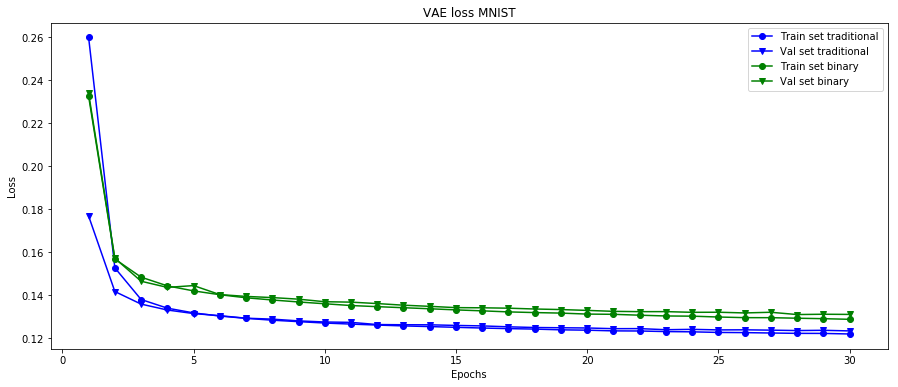

In [12]:
compare_hist_train(hist1,hist2, name_dat)

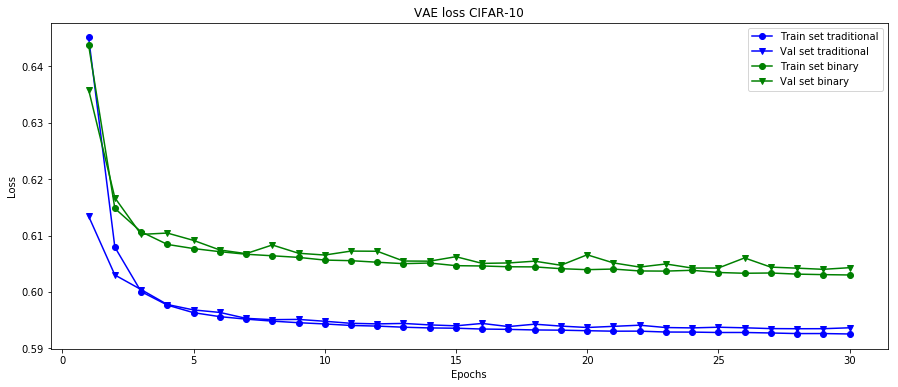

In [33]:
compare_hist_train(hist1,hist2, name_dat)

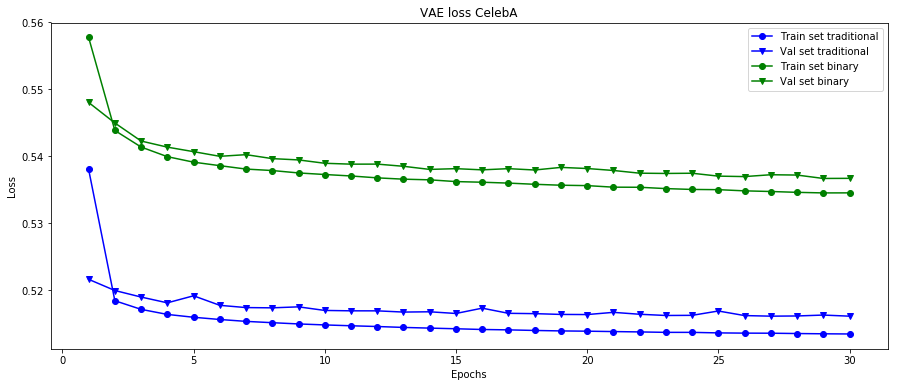

In [52]:
compare_hist_train(hist1,hist2, name_dat) #--64 dim

In [13]:
def show_reconstruct(X, model, low_error=False):
    n = 10
    
    X_hat = model.predict(X)
    idxs = np.arange(len(X))
    if low_error:
        error = np.mean(-X*np.log(X_hat) -(1-X)*np.log(1-X_hat), axis=(1,2,3))
        #values = np.argsort(error)[:n]
        #print(np.sort(error)[:n])
    

    if low_error:
        v = np.mean(error) - 2*np.std(error)
        n_sampleds = np.random.choice( idxs[error < v], size=n, replace=False)
    else:
        n_sampleds = np.random.choice( idxs, size=n, replace=False)
            
    plt.figure(figsize=(20, 4))
    for i,n_i in enumerate(n_sampleds):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(np.squeeze(X[n_i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Imagenes reales")

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.squeeze(X_hat[n_i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("Reconstruccion")
    plt.show()

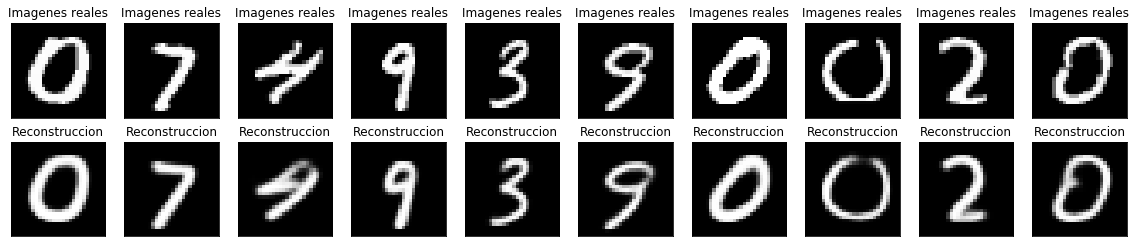

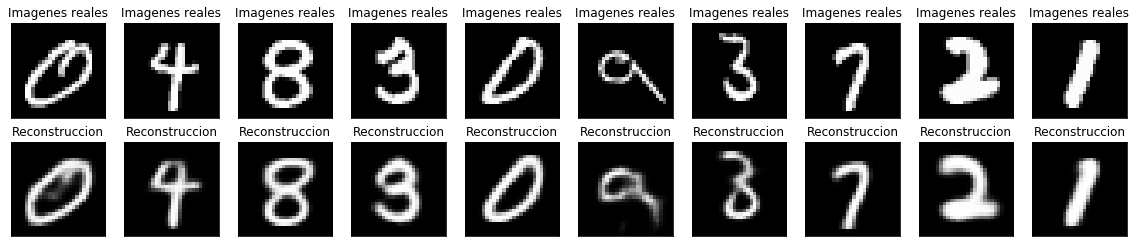

In [14]:
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

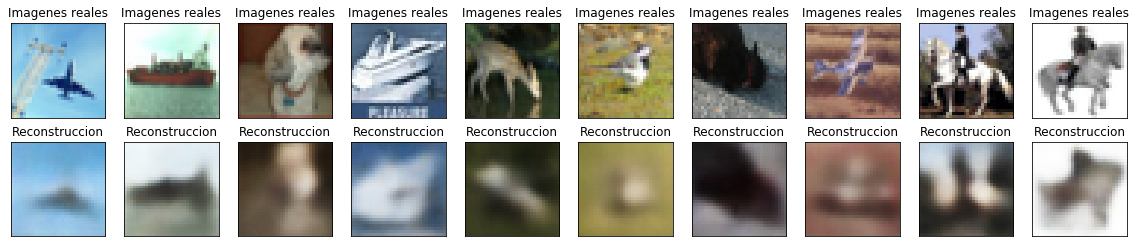

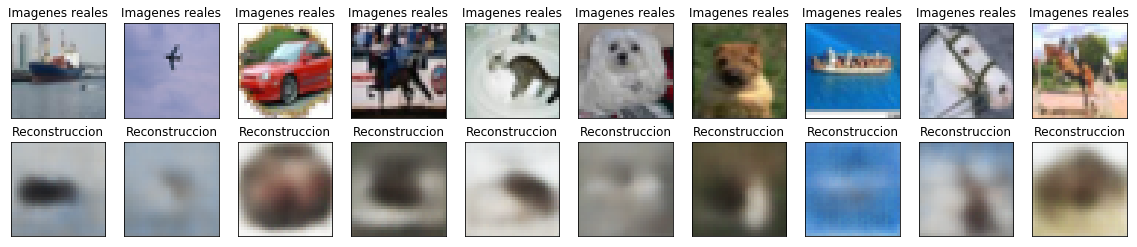

In [34]:
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

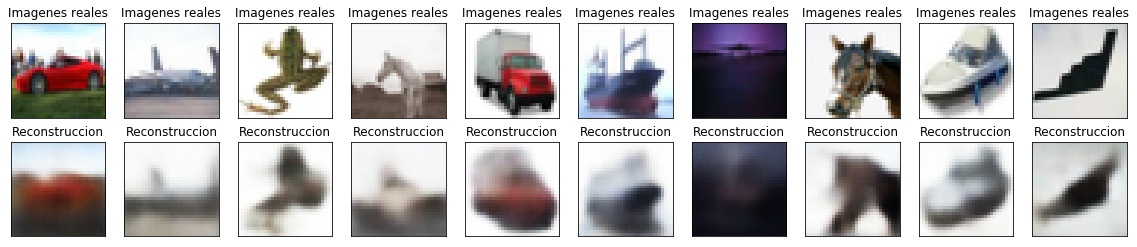

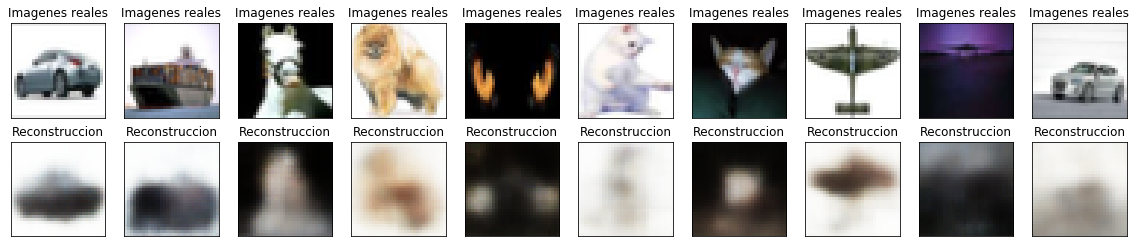

In [35]:
## show low error-images
show_reconstruct(X_test, traditional_vae, low_error=True)

show_reconstruct(X_test, binary_vae, low_error=True)

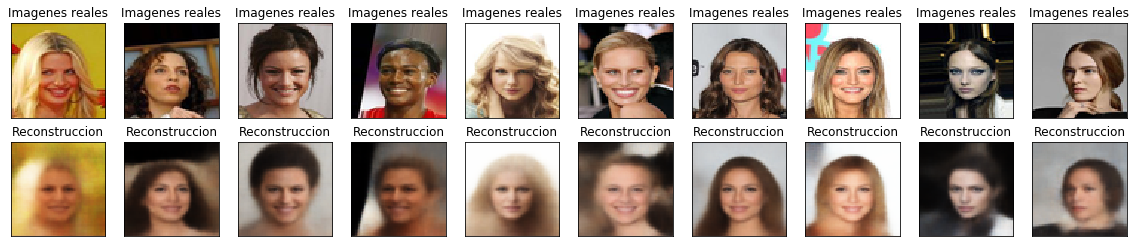

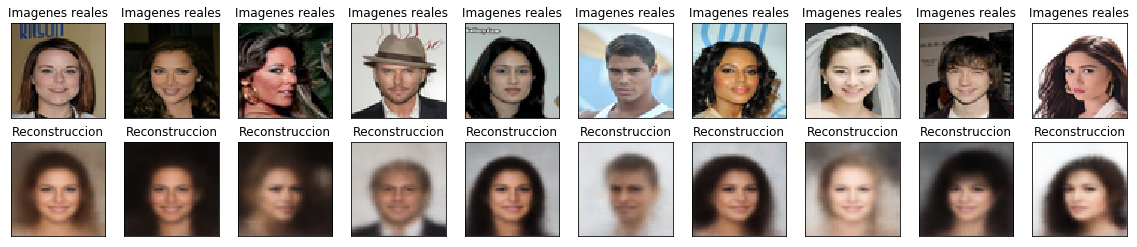

In [53]:
show_reconstruct(X_test, traditional_vae)

show_reconstruct(X_test, binary_vae)

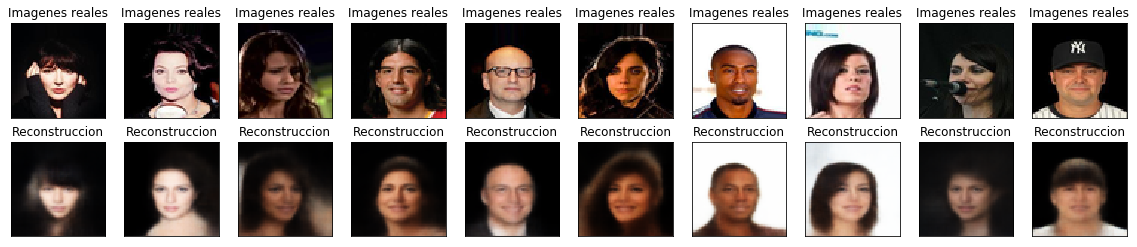

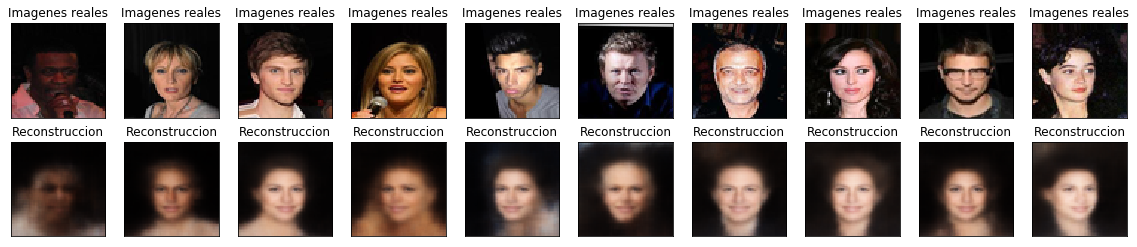

In [54]:
## show low error-images
show_reconstruct(X_test, traditional_vae, low_error=True)

show_reconstruct(X_test, binary_vae, low_error=True)

### Another intrinsic measure: *Classification*


In [15]:
from utils import define_fit

from sklearn.metrics import jaccard_score

results = []
results_B = []

In [55]:
#codify input data (binarize -- or aprox)
X_train_Bcode = keras.activations.sigmoid(encoder_Bvae.predict(X_train)).eval(session=K.get_session())
X_val_Bcode = keras.activations.sigmoid(encoder_Bvae.predict(X_val)).eval(session=K.get_session())
#X_train_Bcode = encoder_Bvae.predict(X_train)
#X_val_Bcode = encoder_Bvae.predict(X_val)

X_train_Tcode = encoder_Tvae.predict(X_train)
X_val_Tcode = encoder_Tvae.predict(X_val)

##codify labels
labels_aux = np.asarray(labels)
def codify_labels(inputs):
    matrix_labels = np.zeros((inputs.shape[0],labels_aux.shape[0]))
    for i,aux_labels in enumerate(inputs):
        if type(aux_labels) == list:
            for aux_label in aux_labels:
                idx = np.where(aux_label==labels_aux)[0]
                matrix_labels[i,idx] = 1 #various-multiple
        else:
            idx = np.where(aux_labels==labels_aux)[0]
            matrix_labels[i,idx] = 1 #only one
    return matrix_labels

C_train = codify_labels(labels_train)
C_val = codify_labels(labels_val)
C_train

array([[0., 1., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [1., 0., 1., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 1., 0., 1.]])

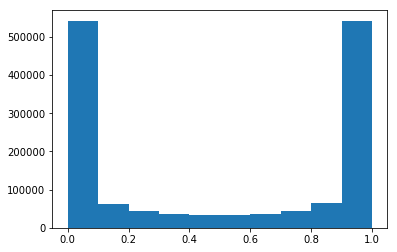

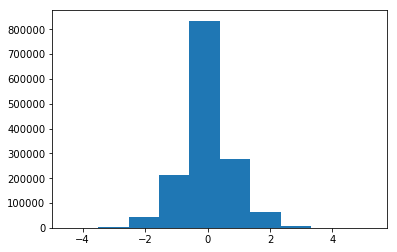

In [58]:
plt.hist(X_train_Bcode.flatten())
plt.show()

plt.hist(X_train_Tcode.flatten())
plt.show()

In [56]:
aux = [name_dat]
multi_label = "CelebA" in aux or "NUSWIDE" in aux

model1 = define_fit(multi_label,X_train_Bcode,C_train)
model2 = define_fit(multi_label,X_train_Tcode,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode)>=0.5)*1, average='micro'))
    
results.append(aux)
print("Done")

Done


In [57]:
for valores in results:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))


Accuracy on dataset:  MNIST
Traditional VAE (train-val): 0.997958 - 0.985667
Binary VAE (train-val): 0.980500 - 0.965000

Accuracy on dataset:  CIFAR-10
Traditional VAE (train-val): 0.574400 - 0.499000
Binary VAE (train-val): 0.476925 - 0.426700

Accuracy on dataset:  CelebA
Traditional VAE (train-val): 0.478815 - 0.472820
Binary VAE (train-val): 0.411556 - 0.407242


In [58]:
#Transform to binary
from utils import MedianHashing

median= MedianHashing()
median.fit(X_train_Tcode)

X_train_Tcode_B = median.transform(X_train_Tcode)
X_val_Tcode_B = median.transform(X_val_Tcode)

X_train_Bcode_B = (X_train_Bcode>0.5)*1
X_val_Bcode_B = (X_val_Bcode>0.5)*1

X_train_Tcode_B

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 1, 1],
       [0, 1, 1, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [59]:
aux = [name_dat]
multi_label = "CelebA" in aux or "NUSWIDE" in aux

model1 = define_fit(multi_label,X_train_Bcode_B,C_train)
model2 = define_fit(multi_label,X_train_Tcode_B,C_train)

if not multi_label:
    aux.append(model2.evaluate(X_train_Tcode_B,C_train,verbose=0)[1])
    aux.append(model2.evaluate(X_val_Tcode_B,C_val,verbose=0)[1])

    aux.append(model1.evaluate(X_train_Bcode_B,C_train,verbose=0)[1])
    aux.append(model1.evaluate(X_val_Bcode_B,C_val,verbose=0)[1])
else:
    aux.append(jaccard_score(C_train, (model2.predict(X_train_Tcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model2.predict(X_val_Tcode_B)>=0.5)*1, average='micro'))

    aux.append(jaccard_score(C_train, (model1.predict(X_train_Bcode_B)>=0.5)*1, average='micro'))
    aux.append(jaccard_score(C_val, (model1.predict(X_val_Bcode_B)>=0.5)*1, average='micro'))
    
results_B.append(aux)
print("Done")

Done


In [60]:
print("Classification on Binary representation")
for valores in results_B:
    print("\nAccuracy on dataset: ",valores[0])
    print("Traditional VAE (train-val): %f - %f"%(valores[1],valores[2]))
    print("Binary VAE (train-val): %f - %f"%(valores[3],valores[4]))

Classification on Binary representation

Accuracy on dataset:  MNIST
Traditional VAE (train-val): 0.906458 - 0.880583
Binary VAE (train-val): 0.963688 - 0.943417

Accuracy on dataset:  CIFAR-10
Traditional VAE (train-val): 0.416350 - 0.354000
Binary VAE (train-val): 0.443550 - 0.392600

Accuracy on dataset:  CelebA
Traditional VAE (train-val): 0.411565 - 0.406540
Binary VAE (train-val): 0.398088 - 0.392483


A través de las curvas de entrenamiento se puede ver que el VAE tradicional obtiene mejores resultados que el binario respecto a la reconstrucción de los datos, lo cual resulta bastante lógico ya que tiene valores más libres en donde pueden vivir las variables (dominio de variable latente: los reales) *vs* el binario que está mucho más restringido (dominio de variable latente: entre 0 y 1). Otra cosa a nombrar es que el modelo con variables latentes binarias reduce el *overfitting* drásticamente, disminuyendo ambas curvas en la misma proporción.

### Results
---
Para evaluar los resultados y poder comparar es necesario realizar el proceso de evaluación en un sistema de recuperación de información. Ésto es recuperar objetos similares a los objetos de una consulta/*query*. Como *baseline* para comparar se utiliza el modelo presentado en *Variational Deep Semantic Hashing* (VDSH).

#### Proceso de evaluación (*content-based retrieval*)
> *Query*: **Documento**

1. Calcular código hashing/binario de cada dato/documento
    * Para *VAE* tradicional se utiliza la mediana de cada componente como *treshold*
    * Para *VAE* binario se utiliza el *treshold* de 0.5 en la probabilidad
2. Recuperar documentos basado en *match* perfecto, *top K* o *ball search* de distancia *hamming* de un documento consulta.
    * En el mismo conjunto/*set*
    * Con *query* recupero sobre *database*
3. Medir *precision* y *recall* en base a algún criterio de relevancia.
    * Documento relevante a otro o no -> Si comparten al menos una clase.
    
|$b_1$|$b_2$|$b_3$|$b_4$|
|---|---|---|---|
||..|..||
|1|0|1|0| 
|1|0|1|1| 
|1|0|0|0| 
|1|0|0|1|
||..|..||

In [10]:
from utils import MedianHashing, get_similar, measure_metrics
from utils import MAP_atk, M_P_atk

In [11]:
#load vae, encoder and generator
encode_train = encoder_Tvae.predict(X_train)
encode_val = encoder_Tvae.predict(X_val)

#para VAE tradicional
median= MedianHashing()
median.fit(encode_train)

train_hash = median.transform(encode_train)
val_hash = median.transform(encode_val)
train_hash

array([[1, 0, 0, ..., 0, 1, 0],
       [1, 1, 0, ..., 1, 1, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 1, 0],
       [0, 1, 0, ..., 1, 0, 0]])

In [12]:
encode_train = encoder_Bvae.predict(X_train) #logits
encode_val = encoder_Bvae.predict(X_val)

#para Binary VAE
probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())

train_hash = (probas_train > 0.5)*1
val_hash = (probas_val > 0.5)*1
train_hash

array([[0, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 1, 1, 0],
       [0, 1, 0, ..., 0, 1, 0]])

In [15]:
val_similares_val =  get_similar(val_hash,train_hash,tipo="EM")
val_similares_val[:2]

[array([], dtype=int64), array([], dtype=int64)]

En algunos casos cuando se busca con un *match* exacto no se encuentra ningún otro dato que se le asigne la misma dirección, es por ésto que se acude a otras técnicas para buscar objetos similares.

In [13]:
%%time
val_similares_train =  get_similar(val_hash, train_hash,tipo="topK",K=100)
val_similares_train[:2]

CPU times: user 36.2 s, sys: 676 ms, total: 36.9 s
Wall time: 36.7 s


In [14]:
%%time
precision,recall = measure_metrics(labels, val_similares_train, labels_query=labels_val, labels_source=labels_train)
print("Precision (query: validation, source: validation) ",precision)
print("Recall    (query: validation, source: validation) ",recall)

Precision (query: validation, source: validation)  0.39340166666666787
Recall    (query: validation, source: validation)  0.00803953689172013
CPU times: user 211 ms, sys: 952 µs, total: 211 ms
Wall time: 210 ms


In [15]:
%%time
v= M_P_atk(val_similares_train, labels_query=labels_val, labels_source=labels_train, K=100)
print("Mean Precision at K(query: validation, source: validation) ",v)

Mean Precision at K(query: validation, source: validation)  0.39340166666666665
CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 98.9 ms


In [16]:
%%time
v = MAP_atk(val_similares_train, labels_query=labels_val, labels_source=labels_train, K=0)
print("MAP at K(query: validation, source: validation) ",v)

MAP at K(query: validation, source: validation)  0.4502512463951747
CPU times: user 3.89 s, sys: 2.11 ms, total: 3.89 s
Wall time: 3.88 s


### Experimentación
---
A continación se realizan las experimentaciones correspondientes para encontrar la mejor arquitectura y mejor configuración del modelo propuesto en base a las métricas *precision* y *recall* del conjunto de validación en el **top 100** de elementos recuperados.

In [26]:
def evaluate_hashing(encoder,train,val,labels_train,labels_val,traditional=True,tipo="topK", MAP=False,K=100):
    encode_train = encoder.predict(train)
    encode_val = encoder.predict(val)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)
        val_train = median.transform(encode_train)
        val_hash = median.transform(encode_val)
    else: #para Binary VAE
        probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
        probas_val = keras.activations.sigmoid(encode_val).eval(session=K.get_session())
        val_train = (probas_train > 0.5)*1
        val_hash = (probas_val > 0.5)*1

    val_similares_train =  get_similar(val_hash, val_train, tipo=tipo,K=K) 
    
    if MAP:
        return MAP_atk(val_similares_train,labels_query=labels_val,labels_source=labels_train, K=0) #all ranking
    else:
        return measure_metrics(labels,val_similares_train,labels_query=labels_val,labels_source=labels_train)


### Experimentando variando el #Bits

In [30]:
traditional_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]}}
binary_dat = {"mnist":{"p":[],"r":[]},"cifar-10":{"p":[],"r":[]},"celeba":{"p":[],"r":[]}}

In [ ]:
Nbits = np.asarray([4,8,16,32,64])
dataset = name_dat.lower()

for Nbit in Nbits:
    traditional_vae, encoder_Tvae, generator_Tvae = define_traditional_VAE(aux_pre_E, aux_G, Nb=Nbit)
    traditional_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_t,r_t = evaluate_hashing(encoder_Tvae,X_train,X_val,labels_train,labels_val,traditional=True,tipo="topK")
    traditional_dat[dataset]["p"].append(p_t) 
    traditional_dat[dataset]["r"].append(r_t) 
    
    binary_vae, encoder_Bvae, generator_Bvae = define_binary_VAE(aux_pre_E, aux_G, Nb=Nbit)
    binary_vae.fit(X_train, X_train, epochs=epochs, batch_size=batch_size,verbose=0)
    p_b,r_b = evaluate_hashing(encoder_Bvae,X_train,X_val,labels_train,labels_val,traditional=False,tipo="topK")
    binary_dat[dataset]["p"].append(p_b) 
    binary_dat[dataset]["r"].append(r_b) 
    
    keras.backend.clear_session()
    gc.collect()

pre-encoder network:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 64)          256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 128)         

In [ ]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["p"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["p"]
t["CelebA"] = traditional_dat["celeba"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["p"]
t["CIFAR-10"] = binary_dat["cifar-10"]["p"]
t["CelebA"] = binary_dat["celeba"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["r"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["r"]
t["CelebA"] = traditional_dat["celeba"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["r"]
t["CIFAR-10"] = binary_dat["cifar-10"]["r"]
t["CelebA"] = binary_dat["celeba"]["r"]
print("\n*** VAE Binary***")
print(t)

In [32]:
print("Resultados de Precision en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["p"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["p"]
t["CelebA"] = traditional_dat["celeba"]["p"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["p"]
t["CIFAR-10"] = binary_dat["cifar-10"]["p"]
t["CelebA"] = binary_dat["celeba"]["p"]
print("\n*** VAE Binary***")
print(t)

print("\nResultados de Recall en validación")
t = Table()
t["N bits"] = Nbits
t["MNIST"] = traditional_dat["mnist"]["r"]
t["CIFAR-10"] = traditional_dat["cifar-10"]["r"]
t["CelebA"] = traditional_dat["celeba"]["r"]
print("\n*** VAE Traditional***")
print(t)
t = Table()
t["N bits"] = Nbits
t["MNIST"] = binary_dat["mnist"]["r"]
t["CIFAR-10"] = binary_dat["cifar-10"]["r"]
t["CelebA"] = binary_dat["celeba"]["r"]
print("\n*** VAE Binary***")
print(t)

Resultados de Precision en validación

*** VAE Traditional***
N bits        MNIST              CIFAR-10            CelebA      
------ ------------------- ------------------- ------------------
     4 0.32771916666668566   0.153245999999999 0.9702043589872069
     8  0.5248099999999909  0.1701189999999976 0.9692766899883796
    16  0.4897216666666712 0.16884299999999974  0.971596617506367
    32  0.4883616666666636 0.16463700000000248 0.9732898776865693
    64  0.5457191666666639 0.16104800000000408  0.973112196104042

*** VAE Binary***
N bits       MNIST              CIFAR-10            CelebA      
------ ------------------ ------------------- ------------------
     4  0.495315833333344  0.1459569999999958 0.9654794382643911
     8 0.6899308333333106 0.17238199999999995 0.9680429858558908
    16 0.6678333333333268  0.1916139999999995  0.970897468163245
    32  0.680065833333323 0.20268100000000006 0.9738717471182952
    64 0.6308891666666621 0.21231900000000045 0.9754673579301957

R

## *Best models facing test set*
Luego de la selección de la mejor configuración de los modelos se evalua de diferentes formas sobre el conjunto de pruebas de los distintos *datasets*, los cambios realizados son:
* Se entrenan sobre todos los datos disponibles (*train+val*)
* Se aumentó el número de *epochs* a 50.

El mejor modelo:
* Simétrica para *Binary VAE* y Base para *Traditional VAE*
* 32 Bits en la codificación (número de variables latentes)
* Representación sobre las top 10 mil *tokens* más frecuentes y *Term Frequency*

In [ ]:
BITS_S = 32

In [ ]:
X_total_input = np.concatenate((X_train,X_val),axis=0)
X_total = np.concatenate((X_train,X_val),axis=0)
labels_total = np.concatenate((labels_train,labels_val),axis=0)
del X_train, X_val, labels_train,labels_val
gc.collect()

In [ ]:
traditional_vae, encoder_Tvae, generator_Tvae = define_traditional_VAE(aux_pre_E, aux_G, Nb=BITS_S)
traditional_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

binary_vae, encoder_Bvae, generator_Bvae = define_binary_VAE(aux_pre_E, aux_G, Nb=BITS_S)
binary_vae.fit(X_total_input, X_total, epochs=50, batch_size=batch_size,verbose=0)

#save model
encoder_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
generator_Tvae.save("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_D_defaultCNN.h5")

encoder_Bvae.save("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
generator_Bvae.save("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN.h5")

keras.backend.clear_session()
gc.collect()

In [ ]:
def evaluate_hashing(encoder,train,test,labels_trainn,labels_testt,traditional=True,tipo="topK",MAP=False,K=100):
    """
        Evaluate Hashing correclty: Query and retrieve on a different set
    """
    encode_train = encoder.predict(train)
    encode_test = encoder.predict(test)
    if traditional:
        median= MedianHashing()
        median.fit(encode_train)
        
        train_hash = median.transform(encode_train)
        test_hash = median.transform(encode_test)
    else: #para Binary VAE
        probas_train = keras.activations.sigmoid(encode_train).eval(session=K.get_session())
        probas_test = keras.activations.sigmoid(encode_test).eval(session=K.get_session())
        
        train_hash = (probas_train > 0.5)*1
        test_hash = (probas_test > 0.5)*1
    
    test_similares_train =  get_similar(test_hash,train_hash,tipo=tipo,K=K)
    if MAP:
        return MAP_atk(test_similares_train,labels_query=labels_testt,labels_source=labels_trainn, K=0) #all ranking
    else:
        return measure_metrics(labels,test_similares_train,labels_testt,labels_destination=labels_trainn)

#to save results
results_dat = {"mnist":{"p":[],"r":[],"map":[]},
               "cifar-10":{"p":[],"r":[],"map":[]},
               "celeba":{"p":[],"r":[],"map":[]}} 

In [ ]:
##load model
encoder_Tvae = keras.models.load_model("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
generator_Tvae = keras.models.load_model("saved_models/"+name_dat+"_VAE_"+str(BITS_S)+"b_D_defaultCNN.h5")

encoder_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_E_defaultCNN.h5")
generator_Bvae = keras.models.load_model("saved_models/"+name_dat+"_BVAE_"+str(BITS_S)+"b_D_defaultCNN.h5")

In [156]:
dataset = name_dat.lower()

p_t,r_t = evaluate_hashing(encoder_Tvae,X_total_input,X_test,labels_total,labels_test,traditional=True,tipo="topK")
results_dat[dataset]["p"].append(p_t)
results_dat[dataset]["r"].append(r_t)
map_t= evaluate_hashing(encoder_Tvae,X_total_input,X_test,labels_total,labels_test,traditional=True,MAP=True,K=9999999)
results_dat[dataset]["map"].append(map_t)


p_b,r_b = evaluate_hashing(encoder_Bvae,X_total_input,X_test,labels_total,labels_test,traditional=False,tipo="topK")
results_dat[dataset]["p"].append(p_b)
results_dat[dataset]["r"].append(r_b)
map_b= evaluate_hashing(encoder_Bvae,X_total_input,X_test,labels_total,labels_test,traditional=False,MAP=True,K=9999999)
results_dat[dataset]["map"].append(map_b)

print("Realizado.")

Realizado.


In [45]:
print("*************Top 100 most similar retrieve*************")

print("\nResultados de Precision en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["p"]
t["CIFAR-10"] = results_dat["cifar-10"]["p"]
t["CelebA"] = results_dat["celeba"]["p"]
print(t)

print("\n\nResultados de Recall en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["r"]
t["CIFAR-10"] = results_dat["cifar-10"]["r"]
t["CelebA"] = results_dat["celeba"]["r"]
print(t)

print("\n\nResultados de MAP en pruebas")
t = Table()
t["Modelo"] = ["Tradicional","Binario"]
t["MNIST"] = results_dat["mnist"]["map"]
t["CIFAR-10"] = results_dat["cifar-10"]["map"]
t["CelebA"] = results_dat["celeba"]["map"]
print(t)

*************Top 100 most similar retrieve*************

Resultados de Precision en pruebas


NameError: name 'results_dat' is not defined

La propuesta presentada de *VAE* binario sobrepasa al *VAE* tradicional en todos los resultados presentados.
### Experimentos con el *ball search*
A continuación se muestra una leve experimentación cuando se trabaja con la búsqueda a través de un radio en el espacio de *Haming*.

In [ ]:
traditional_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for ball radius
binary_dat = {"20news":{"p":[],"r":[]},"snippets":{"p":[],"r":[]},"reuters":{"p":[],"r":[]}} #for ball radius

In [1]:
%%time
dataset = name_dat.lower()

ball_radius = np.arange(0,16) #ball of radius graphic

binary_p = []
binary_r = []
encode_total = encoder_Bvae.predict(X_total_input)
encode_test = encoder_Bvae.predict(X_test)
probas_total= keras.activations.sigmoid(encode_total).eval(session=K.get_session())
probas_test= keras.activations.sigmoid(encode_test).eval(session=K.get_session())
total_hash_b = (probas_total > 0.5)*1
test_hash_b = (probas_test > 0.5)*1
    
traditional_p = []
traditional_r = []
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test)
median= MedianHashing()
median.fit(encode_total)
total_hash_t = median.transform(encode_total)
test_hash_t = median.transform(encode_test)


for ball_r in ball_radius:
    test_similares_train =  get_similar(test_hash_b,total_hash_b,tipo='ball',ball=ball_r) 
    p_b,r_b  = measure_metrics(labels,test_similares_train,labels_test,labels_destination=labels_total)
    binary_dat[dataset]["p"].append(p_b)
    binary_dat[dataset]["r"].append(r_b)
    
    test_similares_train =  get_similar(test_hash_t,total_hash_t,tipo='ball',ball=ball_r) 
    p_t,r_t  = measure_metrics(labels,test_similares_train,labels_test,labels_destination=labels_total)
    traditional_dat[dataset]["p"].append(p_t)
    traditional_dat[dataset]["r"].append(r_t)

print("Termino")

NameError: name 'name_dat' is not defined

In [ ]:
f, axx = plt.subplots(1,3, figsize=(16,5), sharey=True)

b_aux = 10
axx[0].plot(ball_radius[:b_aux],binary_dat["20news"]["p"][:b_aux],'go-',label="precision (Binary VAE)")
axx[0].plot(ball_radius[:b_aux],binary_dat["20news"]["r"][:b_aux],'gv-', label='recall' ) 
axx[0].plot(ball_radius[:b_aux],traditional_dat["20news"]["p"][:b_aux],'bo-',label="precision (Traditional VAE)")
axx[0].plot(ball_radius[:b_aux],traditional_dat["20news"]["r"][:b_aux],'bv-', label='recall' ) 
axx[0].set_ylabel("Score")
axx[0].set_title("20 Newsgroup")
axx[0].legend(bbox_to_anchor=(2, -0.1))

axx[1].plot(ball_radius[:b_aux],binary_dat["reuters"]["p"][:b_aux],'go-')
axx[1].plot(ball_radius[:b_aux],binary_dat["reuters"]["r"][:b_aux],'gv-' ) 
axx[1].plot(ball_radius[:b_aux],traditional_dat["reuters"]["p"][:b_aux][:b_aux],'bo-')
axx[1].plot(ball_radius[:b_aux],traditional_dat["reuters"]["r"][:b_aux],'bv-' ) 
axx[1].set_title("Reuters")

axx[2].plot(ball_radius[:b_aux],binary_dat["snippets"]["p"][:b_aux],'go-')
axx[2].plot(ball_radius[:b_aux],binary_dat["snippets"]["r"][:b_aux],'gv-') 
axx[2].plot(ball_radius[:b_aux],traditional_dat["snippets"]["p"][:b_aux],'bo-')
axx[2].plot(ball_radius[:b_aux],traditional_dat["snippets"]["r"][:b_aux],'bv-') 
axx[2].set_title("Snippets")

for i in range(3):
    axx[i].set_xticks(ball_radius)
    axx[i].set_xlabel("Ball radius")
    axx[i].set_xlim(-0.5, len(ball_radius[:b_aux])-.5)
    axx[i].set_ylim(-0.05)
    
f.suptitle("Comparison of ball search")
plt.show()

en los primeros valores es cercano a 0 ya que defino que si no encuentra datos en la recuperación asigna precisión 0, es decir debe ampliar harto la búsqueda en el espacio de hash/hamming, para encontrar valores. la técnica de Top-K no ve este efecto. Por ejemplo, el espacio de hash en Snippets es mas alejado y disperso entre sí, mienetras que el de Reuters pareciera ser el más compacto (con ball 4 llega al máximo valor).

### Analysis
---
A continuación se realiza el análisis final del modelo binario de *VAE*, gracias a que modela las probabilidades de los códigos binarios directamente es posible interpretarlos a través de las palabras más probables que representan cada *bit* en cada dataset.

1. "Encender" solo un *bit* como *input* al *decoder*/*generator*
2. Realizar un *forward pass* para obtener la distribución de probabilidad de las palabras
3. Obtener las top $M$ palabras más probables.

In [ ]:
def calculate_hash(data,model):
    encode_data = model.predict(data) #logits
    #para Binary VAE
    probas_data = keras.activations.sigmoid(encode_data).eval(session=K.get_session())
    data_hash = (probas_data > 0.5)*1
    return data_hash

from utils import compare_cells_plot

In [ ]:
Nb = encoder_Bvae.output_shape[1]

train_hash = calculate_hash(X_total_input,encoder_Bvae)
test_hash = calculate_hash(X_test,encoder_Bvae)

In [51]:
from sklearn.manifold import TSNE
n = 3000 #data to train
model = TSNE(n_components=2, metric='hamming', init= "random", n_jobs=-1)
train_plot =  model.fit_transform(train_hash[:n])

MNIST


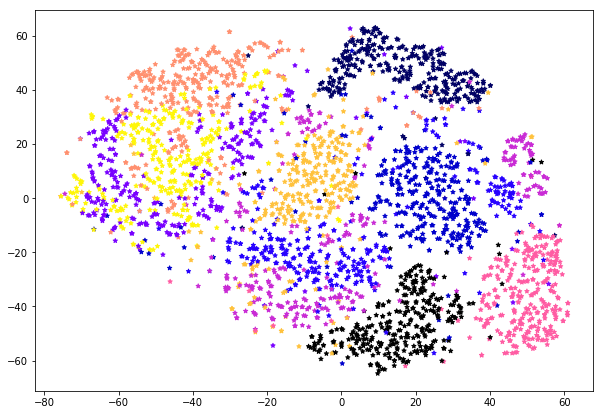

In [163]:
print(name_dat)
colors_plot = np.asarray([plt.cm.gnuplot2(i/C_train.shape[1],1) for i in range(C_train.shape[1])]) #labels??
plt.figure(figsize=(10,7))
plt.scatter(train_plot[:,0],train_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20) 
plt.show()

CIFAR-10


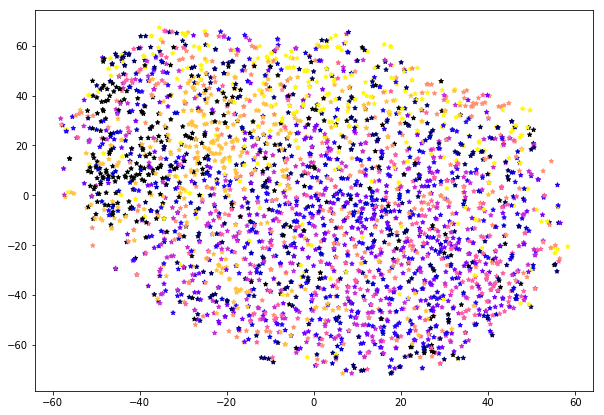

In [52]:
print(name_dat)
colors_plot = np.asarray([plt.cm.gnuplot2(i/C_train.shape[1],1) for i in range(C_train.shape[1])]) #labels??
plt.figure(figsize=(10,7))
plt.scatter(train_plot[:,0],train_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20) 
plt.show()

In [ ]:
print(name_dat)
colors_plot = np.asarray([plt.cm.gnuplot2(i/C_train.shape[1],1) for i in range(C_train.shape[1])]) #labels??
plt.figure(figsize=(10,7))
plt.scatter(train_plot[:,0],train_plot[:,1],c=colors_plot[C_train[:n].argmax(axis=1)],marker="*",s=20) 
plt.show()

Cantidad de memorias en tabla hash:  4294967296
Entrenamiento----
Cantidad de datos a llenar la tabla hash:  50000
Cantidad de memorias ocupadas hash1:  49686
Cantidad de memorias ocupadas hash2:  49953


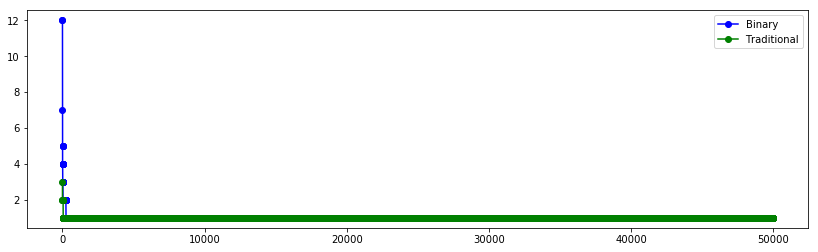

Pruebas-----
Cantidad de datos a llenar la tabla hash:  10000
Cantidad de memorias ocupadas hash1:  9986
Cantidad de memorias ocupadas hash2:  9996


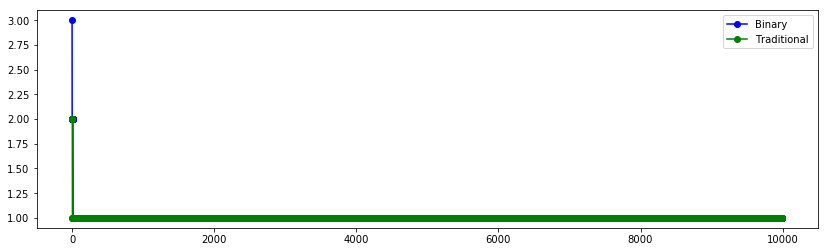

In [53]:
#plot together -- 32 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

Se puede ver que se ocupan varias celdas de memorias gracias a la restricción de las variables latentes en el VAE, donde en la mayoría de los casos se asigna una única dirección de memoria para un objeto, obteniendo una tabla *hashing* distribuidamente poblada.  

> Y si se varía el número de bits?

In [47]:
#plot together--8 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

print("Cantidad de memorias en tabla hash: ",2**Nb)
compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

Cantidad de memorias en tabla hash:  4294967296


NameError: name 'Nb' is not defined

In [ ]:
#plot together--8 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

print("Cantidad de memorias en tabla hash: ",2**Nb)
compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

In [ ]:
#plot together--- 4 bits
encode_total = encoder_Tvae.predict(X_total_input)
encode_test = encoder_Tvae.predict(X_test)
median= MedianHashing()
median.fit(encode_total)
train_hash2 = median.transform(encode_total)
test_hash2 = median.transform(encode_test)

print("Cantidad de memorias en tabla hash: ",2**Nb)
compare_cells_plot(Nb,train_hash,train_hash2,test_hash,test_hash2)

In [56]:
def show_generated_imgs(topI, samplebits):
    NB_reconstruct = []
    
    prob_b = np.ones((1, Nb))*0.5
    for i in range(Nb):
        aux = []
        for K in range(topI):
            b = np.random.binomial(1, prob_b) #random 1 and 0
            b[:, i] = 1 #solo un bit activado 

            reconstruct_data = generator_Bvae.predict(b)[0]
            aux.append(reconstruct_data)

        NB_reconstruct.append(aux)

    bits = np.random.choice(np.arange(Nb),samplebits,replace=False)
    
    for K in range(topI):
        plt.figure(figsize=(17, 10))
        for i in range(samplebits):
            ax = plt.subplot(topI, samplebits, K*samplebits + i + 1)
            I = np.squeeze(NB_reconstruct[bits[i]][K])
            plt.imshow(I)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if K == 0:
                plt.title("bit "+str(bits[i]))
    plt.show()

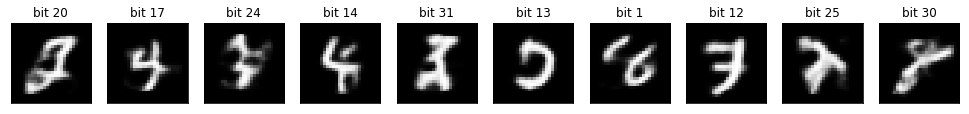

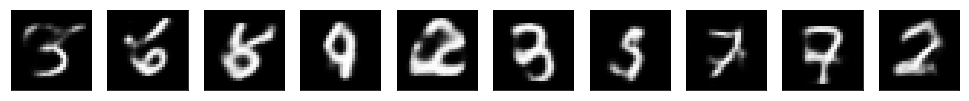

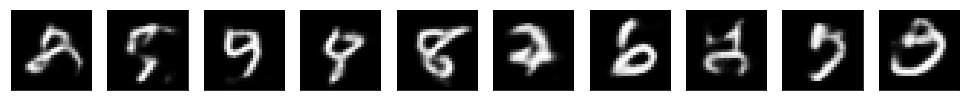

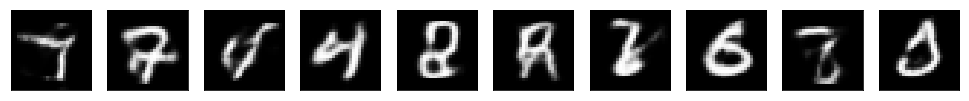

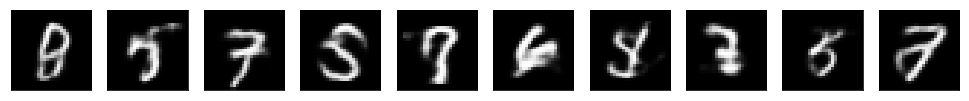

In [287]:
show_generated_imgs(5, 10)

In [57]:
def show_generated_imgs(samplebits, base):
    bits = np.random.choice(np.arange(Nb),samplebits,replace=False) #bits to show

    NB_reconstruct = []
    for i in range(Nb):
        b = np.expand_dims(base, axis=0).copy()
        b[:, i] = 1 #solo un bit con zero 

        reconstruct_data = generator_Bvae.predict(b)[0]
        NB_reconstruct.append(reconstruct_data)
    plt.figure(figsize=(17, 10))
    for i in range(samplebits):
        ax = plt.subplot(1, samplebits,  i + 1)
        I = np.squeeze(NB_reconstruct[bits[i]])

        plt.imshow(I)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("bit "+str(bits[i]) +" on")
    plt.show()
    
     
    NB_reconstruct = []
    for i in range(Nb):
        b = np.expand_dims(base, axis=0).copy()
        b[:, i] = 0 #solo un bit con zero 

        reconstruct_data = generator_Bvae.predict(b)[0]
        NB_reconstruct.append(reconstruct_data)
    plt.figure(figsize=(17, 10))
    for i in range(samplebits):
        ax = plt.subplot(1, samplebits,  i + 1)
        I = np.squeeze(NB_reconstruct[bits[i]])

        plt.imshow(I)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("bit "+str(bits[i])+ " off")
    plt.show()

#### setting base as prior sample

In [58]:
base = np.ones(Nb)*0.5 #prior...
print(base)

base = np.random.binomial(1,base) #b_hat \sim p(b) sample prior  -- dato generico (central)

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]


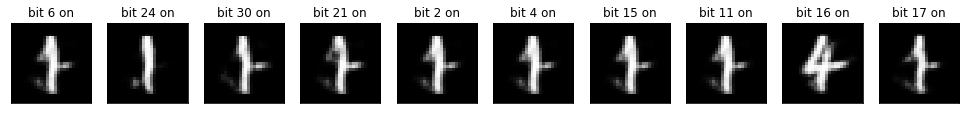

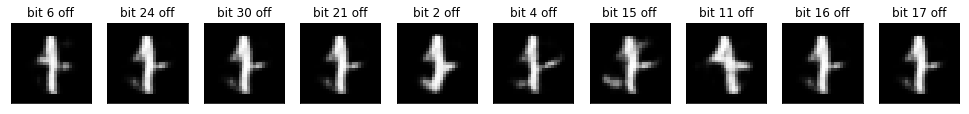

In [139]:
print(name_dat)
show_generated_imgs(10, base=base)

CIFAR-10


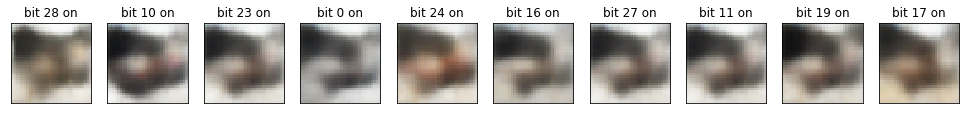

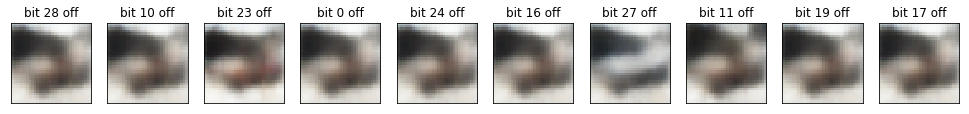

In [59]:
print(name_dat)
show_generated_imgs(10, base=base)

#### setting base as data mean sample -- a litle bit better

In [60]:
base = train_hash.mean(axis=0)
print(base)

base = np.random.binomial(1,base) #b_hat \sim p(b) sample 

[0.53434 0.47546 0.53334 0.38916 0.47654 0.7881  0.508   0.51594 0.39846
 0.73746 0.47884 0.58798 0.41286 0.50444 0.50102 0.4501  0.56332 0.54514
 0.81944 0.6047  0.51756 0.52044 0.47978 0.51196 0.54254 0.34094 0.54508
 0.46378 0.51018 0.5643  0.55948 0.41228]


[0.46461667 0.46041667 0.4778     0.44381667 0.48743333 0.52681667
 0.53151667 0.44141667 0.47636667 0.48281667 0.4854     0.52986667
 0.5334     0.48736667 0.4734     0.56156667 0.50998333 0.44993333
 0.65595    0.45253333 0.55261667 0.48718333 0.52573333 0.45515
 0.53683333 0.34546667 0.57838333 0.48926667 0.57013333 0.4838
 0.51286667 0.49828333]


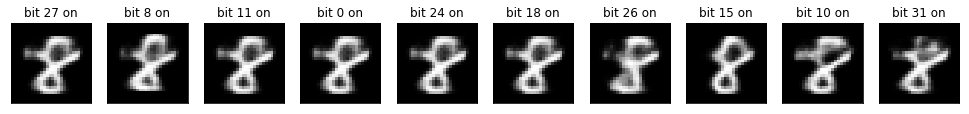

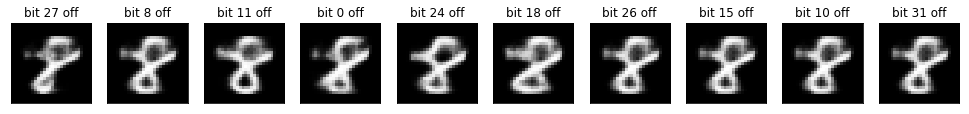

In [140]:
print(name_dat)
show_generated_imgs(10, base=base)

CIFAR-10


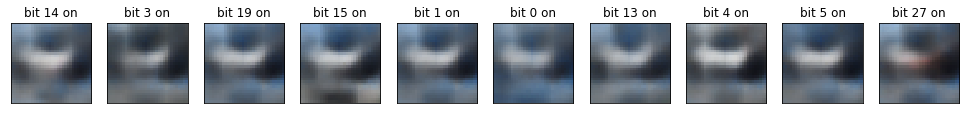

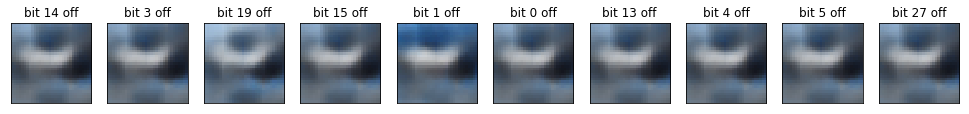

In [61]:
print(name_dat)
show_generated_imgs(10, base=base)

#### setting base as class mean sample

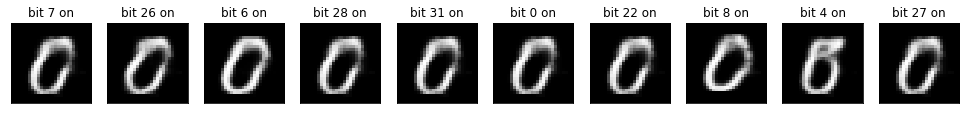

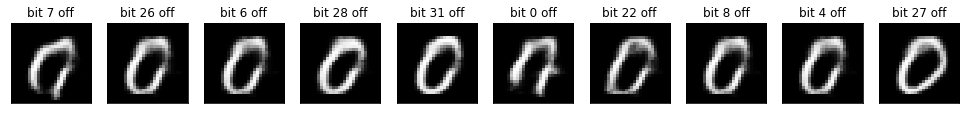

In [141]:
base = train_hash[labels_total=='0'].mean(axis=0) #mean of p(z|y)
base = np.random.binomial(1,base) #b_hat \sim p(b) sample 

show_generated_imgs(10, base=base)

[0.30866212 0.4231682  0.70453871 0.11376446 0.56051617 0.43102937
 0.60634826 0.42776624 0.77454761 0.27039454 0.457876   0.95075645
 0.4374073  0.47775141 0.20765352 0.62726194 0.2558588  0.43266093
 0.99792346 0.36695343 0.41723524 0.50845446 0.56363097 0.52818155
 0.99807179 0.95520617 0.70305547 0.18421833 0.43622071 0.62340552
 0.41842183 0.45283299]


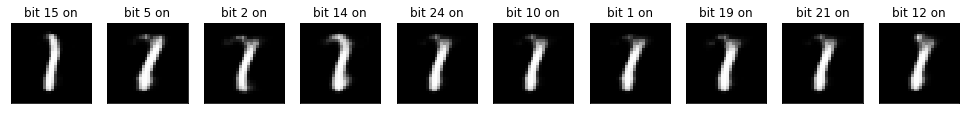

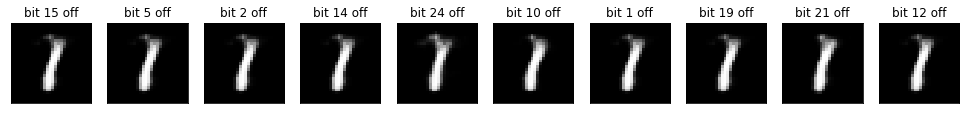

In [148]:
base = train_hash[labels_total=='1'].mean(axis=0) #mean of p(z|y)
print(base)

base = np.random.binomial(1,base) #b_hat \sim p(b) sample 

show_generated_imgs(10, base=base)

[0.7363955  0.3713337  0.48662608 0.72735658 0.57258808 0.02600996
 0.43147021 0.47943184 0.56852979 0.6452684  0.6177827  0.41449917
 0.49750968 0.29256595 0.64895776 0.51853901 0.28334256 0.45305294
 0.7048515  0.40472238 0.58402509 0.32134293 0.49714075 0.30916805
 0.2802066  0.2682162  0.82549345 0.57000553 0.63180225 0.71481277
 0.54676259 0.46947058]


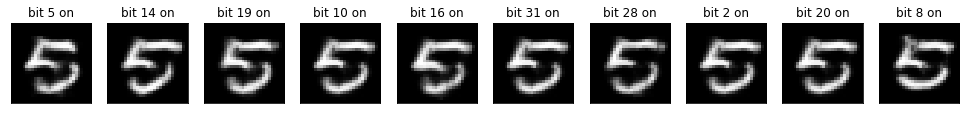

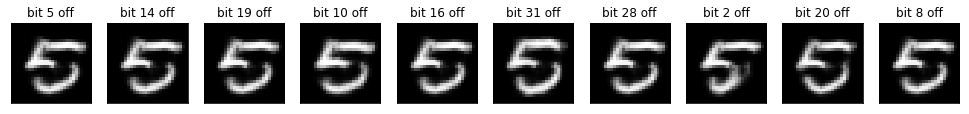

In [144]:
base = train_hash[labels_total=='5'].mean(axis=0) #mean of p(z|y)
print(base)

base = np.random.binomial(1,base) #b_hat \sim p(b) sample 

show_generated_imgs(10, base=base)

[0.5254 0.5428 0.4906 0.4502 0.5124 0.8844 0.5718 0.4256 0.3358 0.691
 0.467  0.6028 0.4366 0.5028 0.4644 0.3938 0.5436 0.5162 0.7166 0.7174
 0.5202 0.577  0.4826 0.4082 0.62   0.4326 0.5586 0.5562 0.5246 0.7054
 0.5326 0.4024]


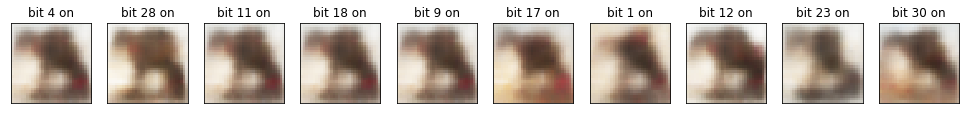

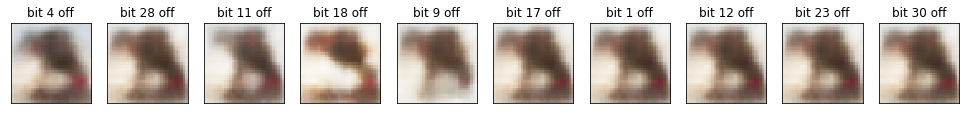

In [84]:
base = train_hash[labels_total=='cat'].mean(axis=0) #mean of p(z|y)
print(base)

base = np.random.binomial(1,base) #b_hat \sim p(b) sample 

show_generated_imgs(10, base=base)

[0.4308 0.4544 0.4756 0.3268 0.4926 0.5986 0.547  0.473  0.4994 0.8238
 0.7098 0.693  0.5014 0.3948 0.6228 0.4858 0.3948 0.4524 0.897  0.341
 0.4908 0.5254 0.4712 0.4658 0.5288 0.1142 0.4544 0.5018 0.4228 0.463
 0.4942 0.5916]


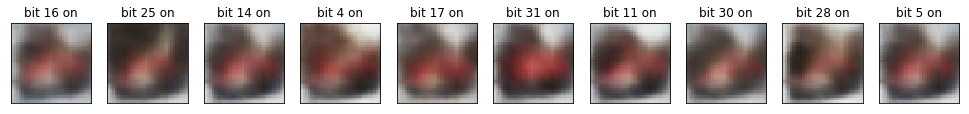

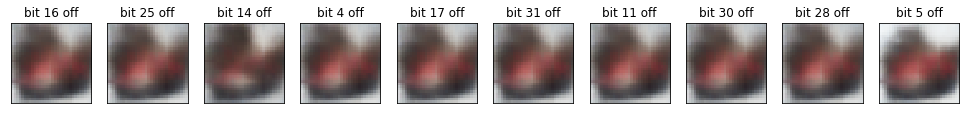

In [169]:
base = train_hash[labels_total=='truck'].mean(axis=0) #mean of p(z|y)
print(base)

base = np.random.binomial(1,base) #b_hat \sim p(b) sample 

show_generated_imgs(10, base=base)

[0.485  0.4762 0.5384 0.3066 0.5366 0.7738 0.5136 0.425  0.484  0.7976
 0.6608 0.5642 0.3994 0.3406 0.6366 0.5094 0.4174 0.3866 0.849  0.6056
 0.4908 0.5314 0.5058 0.5538 0.4716 0.3326 0.3928 0.3998 0.3798 0.5314
 0.4016 0.596 ]


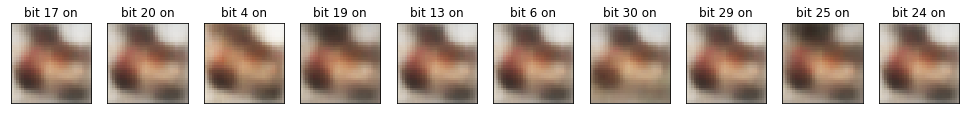

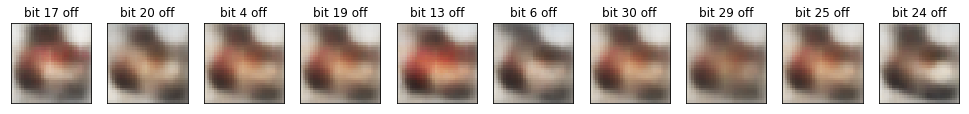

In [170]:
base = train_hash[labels_total=='automobile'].mean(axis=0) #mean of p(z|y)
print(base)

base = np.random.binomial(1,base) #b_hat \sim p(b) sample 

show_generated_imgs(10, base=base)

In [171]:
def show_generated_imgs_class(samplebits, base_class):
    bits = np.random.choice(np.arange(Nb),samplebits,replace=False) #bits to show
    K = len(base_class)
    
    NB_reconstruct = []
    for k in range(K):
        aux = []
        for i in range(Nb):
            b = np.expand_dims(base_class[k], axis=0).copy()
            b[:, i] = 1 - b[:,i] #invertir bit

            reconstruct_data = generator_Bvae.predict(b)[0]
            aux.append(reconstruct_data)

        NB_reconstruct.append(aux)
    
    for k in range(K):
        plt.figure(figsize=(17, 20))
        for i in range(samplebits):
            ax = plt.subplot(K, samplebits, k*samplebits + i + 1)
            I = np.squeeze(NB_reconstruct[k][bits[i]])
            plt.imshow(I)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if k == 0:
                plt.title("bit "+str(bits[i]))
    plt.show()

In [179]:
base_class = []

for value in labels:
    aux_p = train_hash[labels_total==value].mean(axis=0) #mean of p(z|y)
    aux = np.random.binomial(1, aux_p) #b_hat \sim p(b) sample 
    base_class.append(aux)

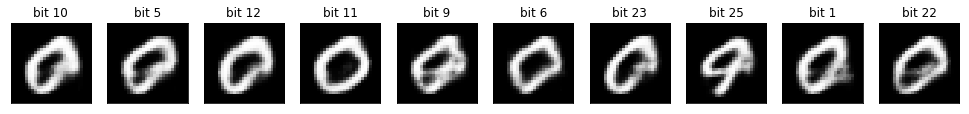

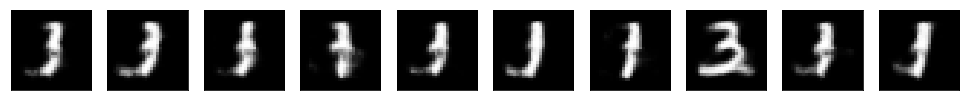

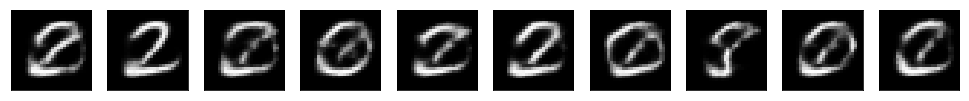

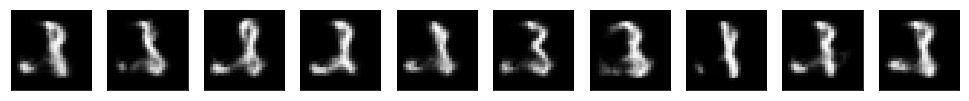

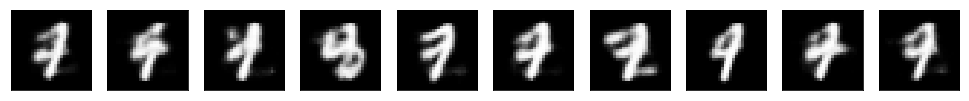

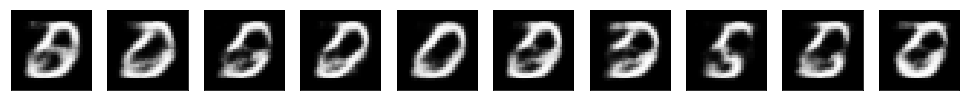

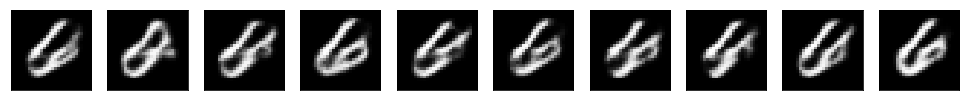

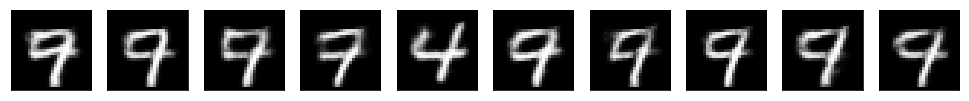

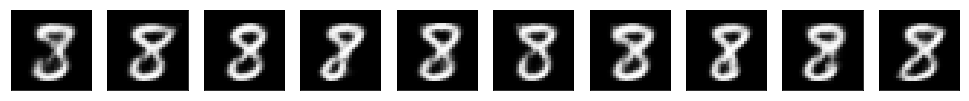

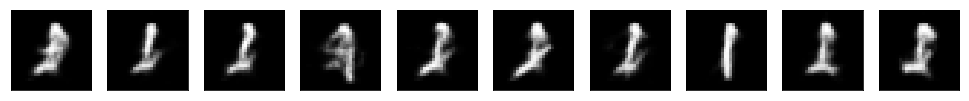

In [149]:
print(name_dat)
show_generated_imgs_class(10, base_class) #bit se invierte.. (para ver el efecto/impacto)

CIFAR-10


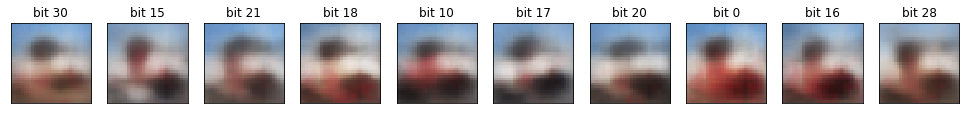

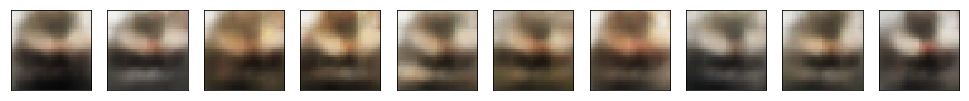

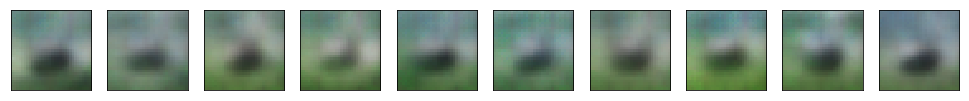

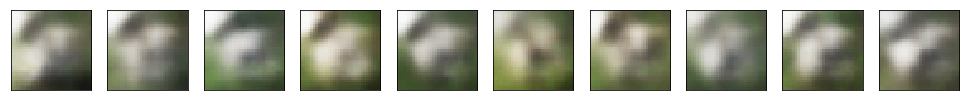

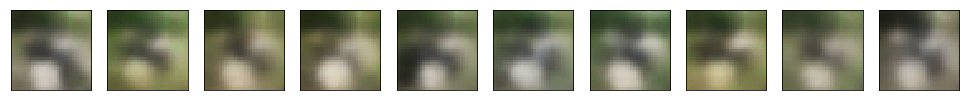

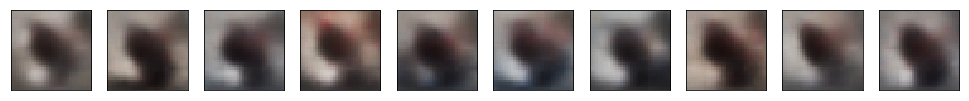

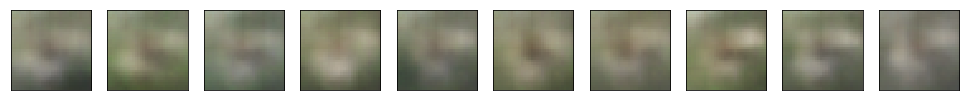

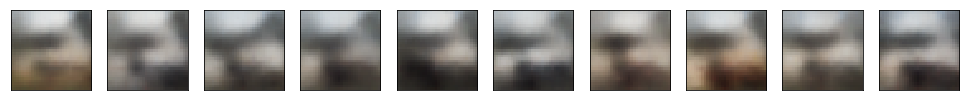

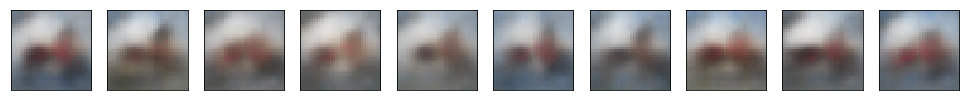

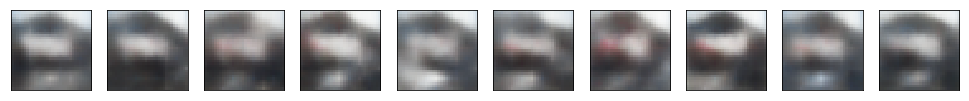

In [180]:
print(name_dat)
show_generated_imgs_class(10, base_class) #bit se invierte.. (para ver el efecto/impacto)

In [181]:
#https://github.com/Schlumberger/joint-vae
    
def img_editing(samplebits, img_code):
    bits = np.random.choice(np.arange(Nb),samplebits,replace=False)

    base = np.expand_dims(img_code, axis=0)
    I = generator_Bvae.predict(base)[0]
    plt.imshow(np.squeeze(I))
    plt.show()
        
    bs_1 = np.tile(base, (Nb,1))
    bs_0 = np.tile(base, (Nb,1))
    for i in range(Nb):        
        bs_1[i,i] = 1 #solo un bit activado 
        bs_0[i,i] = 0 #apagado 
    NB_reconstruct_1 = generator_Bvae.predict(bs_1)
    NB_reconstruct_0 = generator_Bvae.predict(bs_0)
    
    plt.figure(figsize=(17, 10))
    for i in range(samplebits):
        ax = plt.subplot(2, samplebits, i + 1)
        I = np.squeeze(NB_reconstruct_1[bits[i]])
        plt.imshow(I)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.title("bit "+str(bits[i]))
            
    plt.figure(figsize=(17, 10))
    for i in range(samplebits):
        ax = plt.subplot(2, samplebits, samplebits + i + 1)
        I = np.squeeze(NB_reconstruct_0[bits[i]])
        plt.imshow(I)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [276]:
b_samp = train_hash[np.random.choice(len(train_hash))] #sampled data
b_samp

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

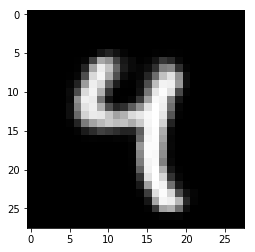

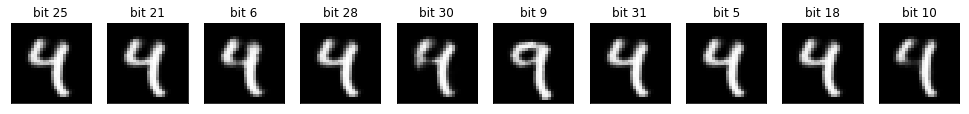

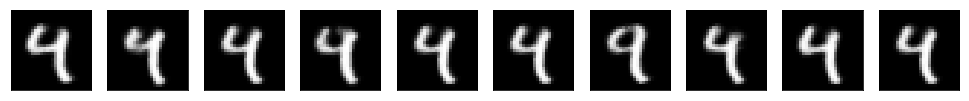

In [277]:
img_editing(10, img_code=b_samp) #variacion solo es apagado o encendido

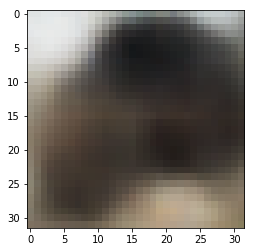

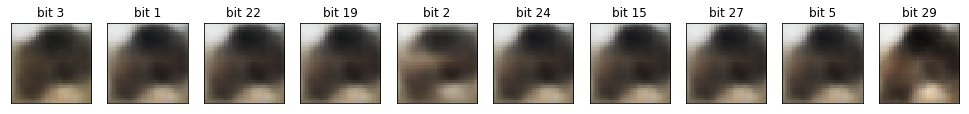

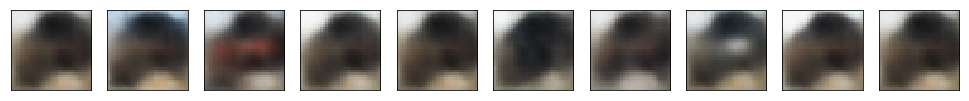

In [210]:
img_editing(10, img_code=b_samp) #variacion solo es apagado o encendido

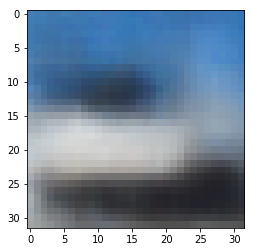

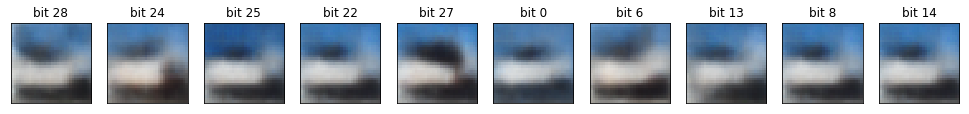

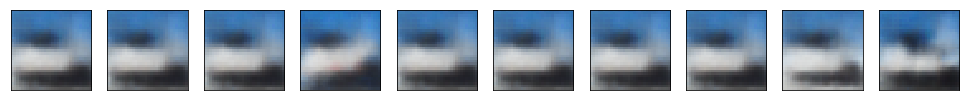

In [242]:
img_editing(10, img_code=b_samp) #variacion solo es apagado o encendido

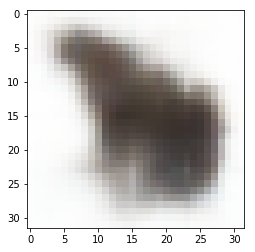

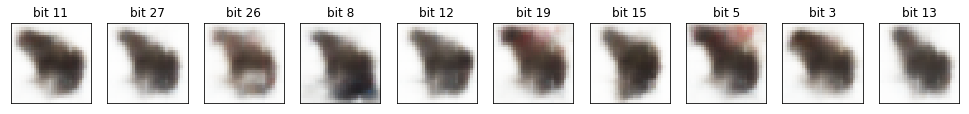

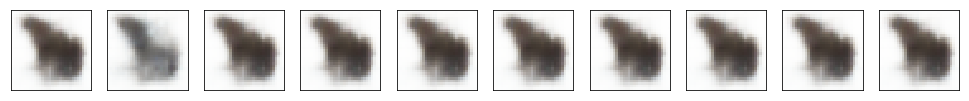

In [253]:
img_editing(10, img_code=b_samp) #variacion solo es apagado o encendido

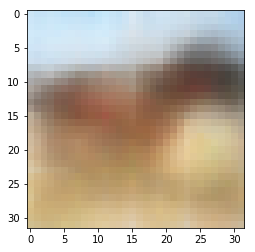

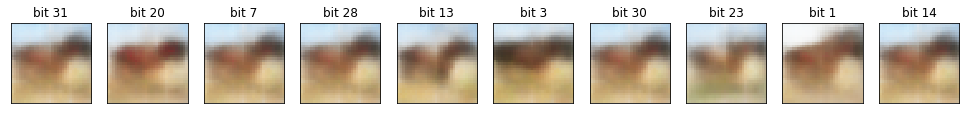

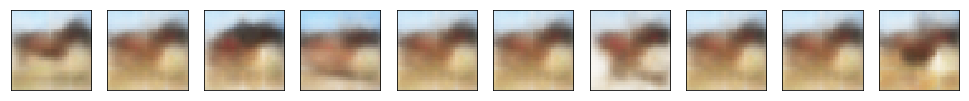

In [286]:
img_editing(10, img_code=b_samp) #variacion solo es apagado o encendido

La idea de todo lo anterior es buscar visualizar qué variación provoca cada bit.

In [278]:
#https://github.com/Schlumberger/joint-vae
    
def bit_transitions(samplebits, img_code, T=5):
    bits = np.random.choice(np.arange(Nb),samplebits,replace=False)

    base = np.expand_dims(img_code, axis=0)
    I = generator_Bvae.predict(base)[0]
    plt.imshow(np.squeeze(I))
    plt.show()
    
    rec_T = []
    for value in np.linspace(0,1, T):
        bs = np.tile(base, (Nb,1))
        for i in range(Nb):        
            bs[i,i] = value
        
        rec_T.append(generator_Bvae.predict(bs))

    for t in range(T):
        plt.figure(figsize=(17, 20))
        for i in range(samplebits):
            ax = plt.subplot(T, samplebits, t*samplebits + i + 1)
            I = np.squeeze(rec_T[t][bits[i]])
            plt.imshow(I)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            if t == 0:
                plt.title("bit "+str(bits[i]))
    plt.show()

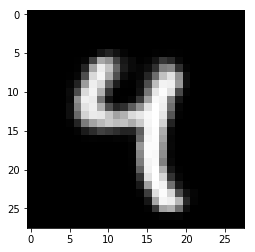

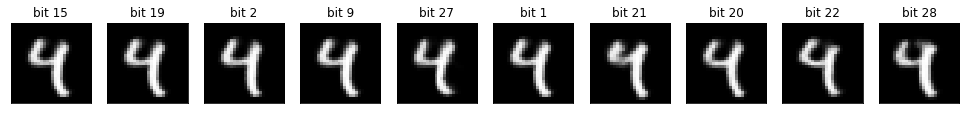

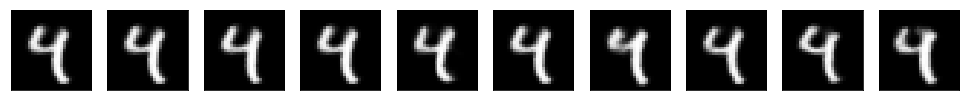

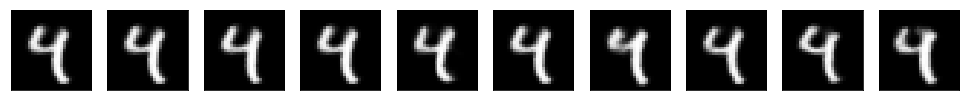

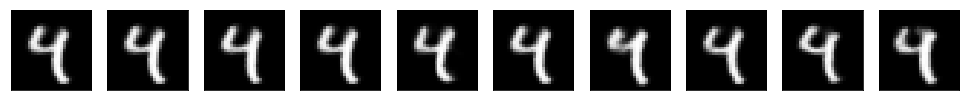

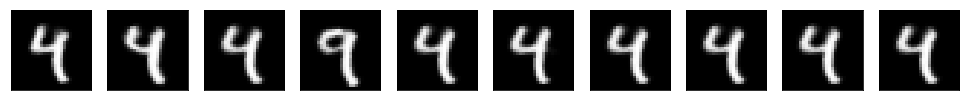

In [285]:
##toda la transicion de bit 0 a 1 
bit_transitions(10, b_samp, T=5)

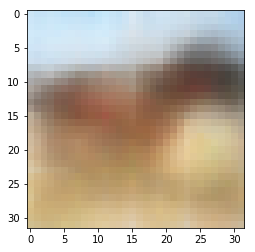

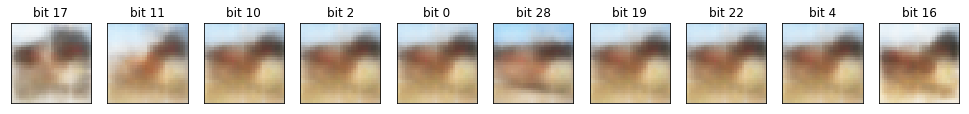

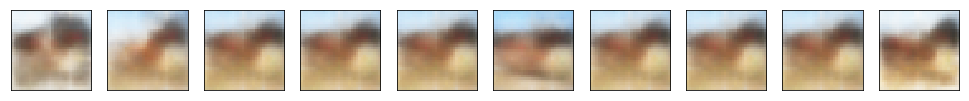

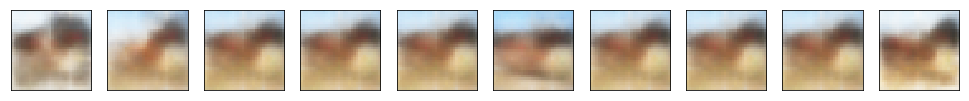

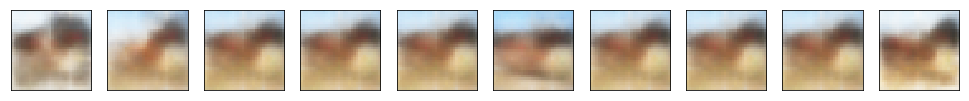

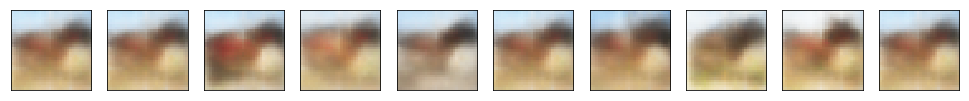

In [288]:
##toda la transicion de bit 0 a 1 
bit_transitions(10, b_samp, T=5)

In [ ]:
se puede mostrar "visualmente" si entrea un dato como query, qué imagenes retorna 
